In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random

from keras.preprocessing import image
import keras.backend as K

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.framework import ops
tf.compat.v1.disable_eager_execution() # required for GBP to work unless Gradient Tape is used

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

#from contextlib import redirect_stdout

#### Globals

In [3]:
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] 
SCENARIO_LIST = ["PrPo_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [4]:
m = models.load_model(FULL_MODEL_PATH)

In [4]:
def plotOriginal(ind, color_map='gray'):
    trial_seed = 1
    grad_cam_single_dir = '../../figures/plottingGradCam/examples/'
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
        
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    print(validation_labels[[ind]])
    if color_map=='gray':
        plt.imshow(np.squeeze(validation_images[ind], axis=2), cmap='gist_gray')
    else:
        plt.imshow(np.squeeze(validation_images[ind], axis=2))
    
#     if not os.path.exists(grad_cam_single_dir):
#         os.makedirs(grad_cam_single_dir)
    plt.tight_layout()
#     plt.savefig(grad_cam_single_dir+'singe-'+str(ind)+'-'+str(validation_labels[ind])+'.jpg')

Working version of Guided Backpropagation

In [5]:
def guided_backprop(index):#101
    trial_seed = 1
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    assert validation_labels[index].mean(axis=0)[0] == 0
    cam_list = index
    
    backprop_images = validation_images[cam_list]
    
    def register_gradient():
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                    tf.cast(op.inputs[0] > 0., dtype)

    def modify_backprop(model, name, monochrome=True):
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': name}):

            # get layers that have an activation
            layer_dict = [layer for layer in model.layers[1:]
                          if hasattr(layer, 'activation')]

            # replace relu activation
            for layer in layer_dict:
                if layer.activation == tf.keras.activations.relu:
                    layer.activation = tf.nn.relu

            # re-instanciate a new model
            new_model = models.load_model(FULL_MODEL_PATH)
            
        return new_model

    def guided_backpropagation(img_tensor, model, activation_layer):
        model_input = model.input
        layer_output = model.get_layer(activation_layer).output

        max_output = K.max(layer_output, axis=3)

        get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
        saliency = get_output([img_tensor])
        
        return saliency[0]
    
    register_gradient()
    guided_model = modify_backprop(m, 'GuidedBackProp')
    gradient = guided_backpropagation(backprop_images, guided_model, 'conv2d_4')
    
    return gradient, index

In [6]:
guided_backprop([101])[0]

array([[[[ 0.00078276],
         [ 0.00158801],
         [ 0.00218869],
         ...,
         [ 0.00227443],
         [ 0.00229405],
         [ 0.00293886]],

        [[-0.00129388],
         [ 0.00819799],
         [ 0.00800379],
         ...,
         [ 0.01349041],
         [ 0.00719786],
         [ 0.00643284]],

        [[-0.00017844],
         [ 0.00557406],
         [ 0.00375208],
         ...,
         [ 0.00781585],
         [-0.00068772],
         [ 0.00439347]],

        ...,

        [[-0.00226742],
         [ 0.01518545],
         [ 0.0040855 ],
         ...,
         [ 0.00394544],
         [-0.00021767],
         [ 0.00622715]],

        [[ 0.00151458],
         [ 0.00420545],
         [ 0.00502296],
         ...,
         [ 0.00226174],
         [ 0.00298391],
         [ 0.00417192]],

        [[ 0.00319271],
         [ 0.00802812],
         [-0.00247717],
         ...,
         [ 0.00798536],
         [ 0.01017314],
         [ 0.00966706]]]], dtype=float32)

In [9]:
guided_backprop([101])[0]

array([[[[ 0.00078276],
         [ 0.00158801],
         [ 0.00218869],
         ...,
         [ 0.00227443],
         [ 0.00229405],
         [ 0.00293886]],

        [[-0.00129388],
         [ 0.00819799],
         [ 0.00800379],
         ...,
         [ 0.01349041],
         [ 0.00719786],
         [ 0.00643284]],

        [[-0.00017844],
         [ 0.00557406],
         [ 0.00375208],
         ...,
         [ 0.00781585],
         [-0.00068772],
         [ 0.00439347]],

        ...,

        [[-0.00226742],
         [ 0.01518545],
         [ 0.0040855 ],
         ...,
         [ 0.00394544],
         [-0.00021767],
         [ 0.00622715]],

        [[ 0.00151458],
         [ 0.00420545],
         [ 0.00502296],
         ...,
         [ 0.00226174],
         [ 0.00298391],
         [ 0.00417192]],

        [[ 0.00319271],
         [ 0.00802812],
         [-0.00247717],
         ...,
         [ 0.00798536],
         [ 0.01017314],
         [ 0.00966706]]]], dtype=float32)

Visualizing GBP output

In [15]:
def render_backprop(gradient, index, color_map='jet'):
    # Generate heatmap with BackProp for a single image
    backprop_dir = '../../figures/plottingBackProp/'
    plt.tight_layout()
#     plt.figure(0)
    plt.figure(figsize=(5, 5))
    if color_map != 'jet':
        plt.imshow(np.squeeze(gradient), cmap='gist_gray')
    else:
        plt.imshow(np.squeeze(gradient), cmap='jet')
    plt.axis('off')
    if not os.path.exists(backprop_dir):
        os.makedirs(backprop_dir)
    plt.savefig(backprop_dir+"/single-backprop-index" + "-" + str(index) +"-images.png",bbox_inches='tight')

In [16]:
backprop, index = guided_backprop([180])

[[0 1]]


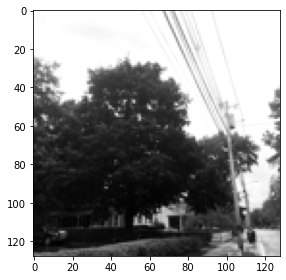

In [12]:
plotOriginal(17)

<Figure size 432x288 with 0 Axes>

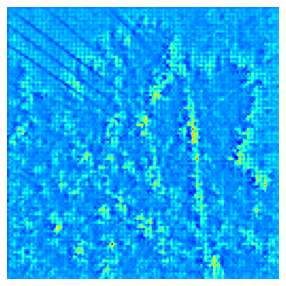

In [17]:
render_backprop(backprop, index)

<Figure size 432x288 with 0 Axes>

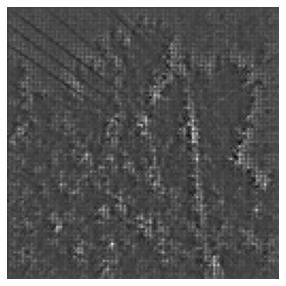

In [14]:
render_backprop(backprop, index, color_map='gray')